In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random as rand

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (16, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [2]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Linear Regression

In [83]:
class Linear_Regression:
    
    def __init__(self, x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-10, 
                                         step_size = 1e-1):
        
        # init weights 
        self.weights = np.zeros(x_train.shape[1])
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test      
        
        # init vars
        self.max_iters = int(max_iters)
        self.tolerance = tolerance
        self.step_size = step_size
        
    
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])
    
    def MAE(self, y_pred, y_test):
        return (np.mean(np.abs(y_pred-y_test)))
    
    def gradient_descent(self, x_train, y_train, weights):        
        
        y_pred = x_train.dot(weights)
        init_loss = self.MSE(y_pred, y_train) 
        
        store_loss = []
        store_loss.append(init_loss)
        
        for i in range(self.max_iters):
            
            # calc predicted y with weights and resulting error
            y_pred = x_train.dot(weights)
            error = y_pred - y_train
            
            # calc gradient and adjust weights in direction of negative grad
            grad = x_train.T.dot(error) / x_train.shape[0]
            weights -= grad*self.step_size 
            
            # calc and store loss of new y predicted
            y_pred = x_train.dot(weights)
            store_loss.append(self.MSE(y_pred, y_train) )
            
            # if the progress is less than the tolerance, it has converged
            if np.abs( store_loss[-2] - store_loss[-1] ) <= self.tolerance:
                print('Converged!')
                break
            
            # decrease step size if error increases
            if store_loss[-1] > store_loss[-2]:
                self.step_size *= 0.50
            
        return weights, store_loss
        
        
    def fit(self, x_train, y_train):
        # perform gradient descent
        optimal_weights, store_loss = self.gradient_descent(x_train, 
                                                            y_train,
                                                            self.weights)
        self.optimal_weights = optimal_weights
        self.loss = store_loss
        
        return optimal_weights, store_loss
        
    def predict(self, x_test):   
        
        y_pred = x_test.dot(self.optimal_weights) 
        MSE = self.MSE(y_pred, self.y_test)
        
        return y_pred, MSE

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

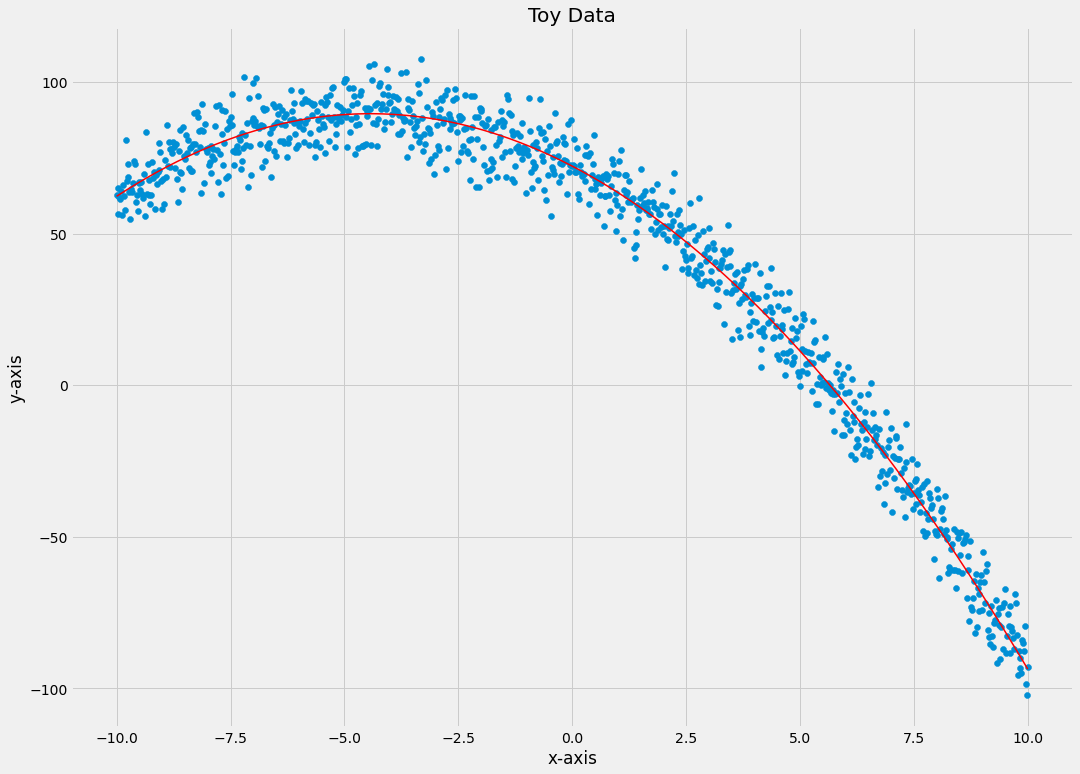

In [26]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    y_actual = []
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
            y_actual.append(a*x[i] + b)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            y_actual.append(a*x[i]**exp + b*x[i] + c)
            
    return x, y, y_actual
    
x, y, y_actual = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.plot(x,y_actual, c = 'r', linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [27]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

In [28]:
# instantiate LR class with data
LR = Linear_Regression(x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-10, 
                                         step_size = 1e-1)

opt_w, loss = LR.fit(x_train,y_train) # fit model to training data

y_pred, MSE = LR.predict(x_test) # predict y from test data
print("Mean Squared Error: {}".format(MSE))

Converged!
Mean Squared Error: 0.14075186807289347


In [29]:
# unnormalize data
x_test, y_test = unnormalize(x_test, test[1]['x'], test[2]['x']), unnormalize(y_test, test[1]['y'],  test[2]['y'])
y_pred = unnormalize(y_pred, test[1]['y'],  test[2]['y'])

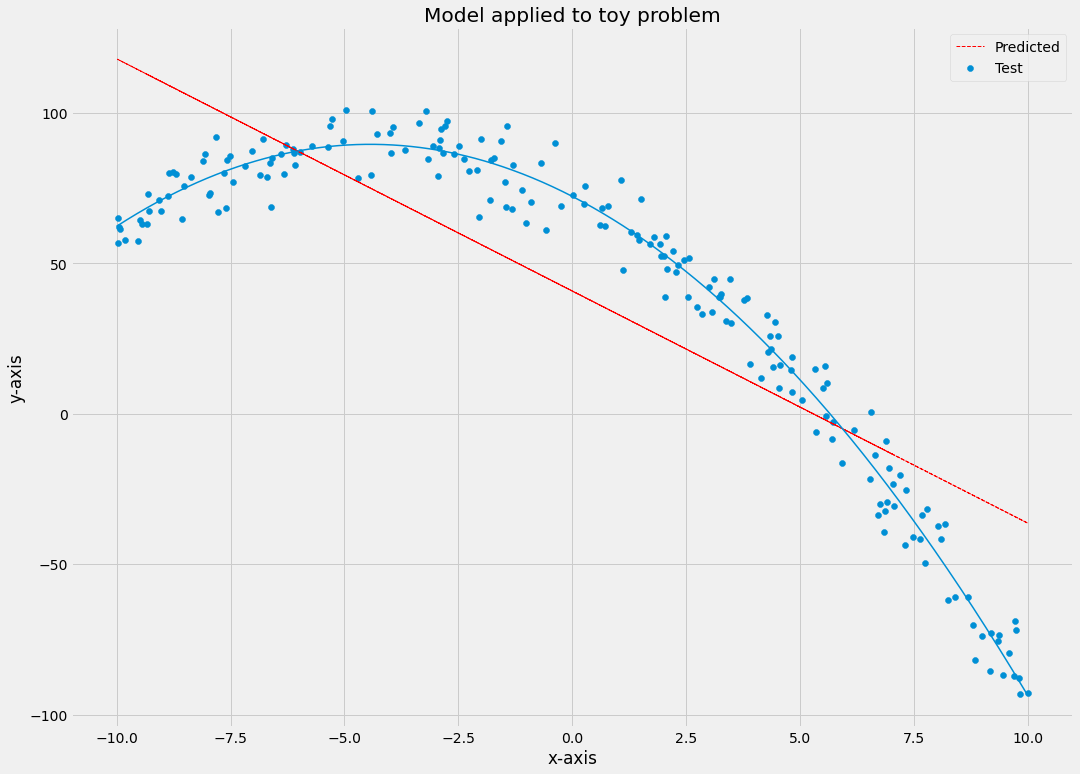

In [30]:
# plot toy data and model prediction

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(x_test,y_pred, 
         c = 'red', 
         linewidth = 1, 
         label = 'Predicted', 
         linestyle = '--')
plt.plot(x,y_actual, linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Model applied to toy problem')
plt.legend()

# Import and process data

In [48]:
# load dataframe from csv file
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
#df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

# Run Model to Predict Crop Yield

In [10]:
# instantiate class with hyperparameters and data
LR = Linear_Regression(x_train, y_train, x_test, y_test, 
                                         max_iters = 1e5, 
                                         tolerance = 1e-5, 
                                         step_size = 1e-5)

# fit model to training data
weights, loss = LR.fit(x_train, y_train)

# use model to make predictions from test data
y_pred, MSE = LR.predict(x_test)

print("Mean Squared Error: {}".format(MSE))
df_w = pd.DataFrame(weights, columns = ['Coefficient'])
np.transpose(df_w) # show linear regression coefficients

Converged!
Mean Squared Error: 0.4344487787750469


,jan rain,jan mean min temperature,jan mean max temperature,feb rain,feb mean min temperature,feb mean max temperature,mar rain,mar mean min temperature,mar mean max temperature,apr rain,...,sep mean max temperature,oct rain,oct mean min temperature,oct mean max temperature,nov rain,nov mean min temperature,nov mean max temperature,dec rain,dec mean min temperature,dec mean max temperature
Coefficient,-0.000957,-0.012294,-0.013204,-0.00026,-0.0126,-0.013311,0.000426,-0.012437,-0.012648,0.002104,...,-0.00546,0.002748,-0.009664,-0.010669,0.000856,-0.011447,-0.012552,-0.000303,-0.011942,-0.013002


In [11]:
# unnormalize
y_test = unnormalize(y_test, test[1][-1],  test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

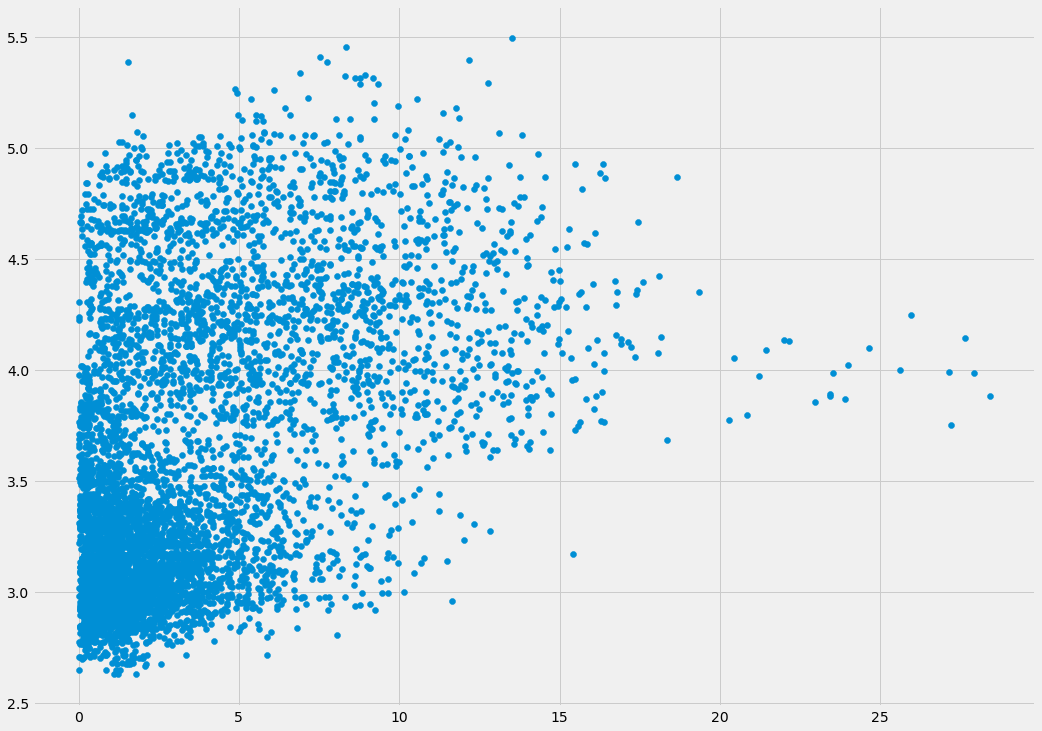

In [12]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'])

In [13]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.463652
y_pred,0.463652,1.000000


# Hyperparameter optimization with test data

In [14]:
stepsize_space = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
tolerance_space = [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for step in stepsize_space:
    for tol in tolerance_space:
    
        iteration += 1

        # start timer
        start = time.time()

        # instantiate class with hyperparameters and data
        LR = Linear_Regression(x_train, y_train, x_test, y_test, 
                                                 max_iters = 1e5, 
                                                 tolerance = tol, 
                                                 step_size = step)

        # fit model to training data
        weights, loss = LR.fit(x_train, y_train)

        # use model to make predictions from test data
        y_pred, MSE = LR.predict(x_test)

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[step, tol]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        #print("Current Step:", step, ' MSE: ', MSE)
        if MSE < previous_MSE:
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

Converged!
0
Converged!
1
Converged!
2
Converged!
3
Converged!
4
Converged!
5
Converged!
6
Converged!
7
Converged!
8
Converged!
9
Converged!
10
Converged!
11
Converged!
12
Converged!
13
Converged!
14
Converged!
15
Converged!
16
Converged!
17
Converged!
18
Converged!
19
Converged!
20
Converged!
21
Converged!
22
Converged!
23
Converged!
24
Converged!
25
Converged!
26
27
Converged!
28
Converged!
29
Converged!
30
Converged!
31
Converged!
32
Converged!
33
34
Converged!
35
Converged!
36
Converged!
37
Converged!
38
Converged!
39
Converged!
40
41
Converged!
42
Converged!
43
Converged!
44
Converged!
45
Converged!
46
47
48
Converged!
49
Converged!
50
Converged!
51
Converged!
52
Converged!
53
54
55
Converged!
56
Converged!
57
Converged!
58
Converged!
59
Converged!
60
Converged!
61
62
Converged!
63
Converged!
64
Converged!
65
Converged!
66
Converged!
67
Converged!
68
Converged!
69


## Save optimal hyperparameters

In [41]:
i = best_results['iteration']
print(results[i])

{'params': [0.1, 1e-08], 'MSE': 12.166373054088101, 'runtime': 10.311535120010376}


In [42]:
best_tol = results[i]['params'][1]
best_step = results[i]['params'][0]

## Run linear regression model with validation data using optimal hyperparameters

In [49]:
LR = Linear_Regression(x_train, y_train, x_valid, y_valid, 
                                                 max_iters = 1e5, 
                                                 tolerance = best_tol, 
                                                 step_size = best_step)

# fit model to training data
weights, loss = LR.fit(x_train, y_train)

# use model to make predictions from test data
y_pred_validation, MSE = LR.predict(x_valid)

Converged!


In [50]:
y_pred_validation = unnormalize(y_pred_validation, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

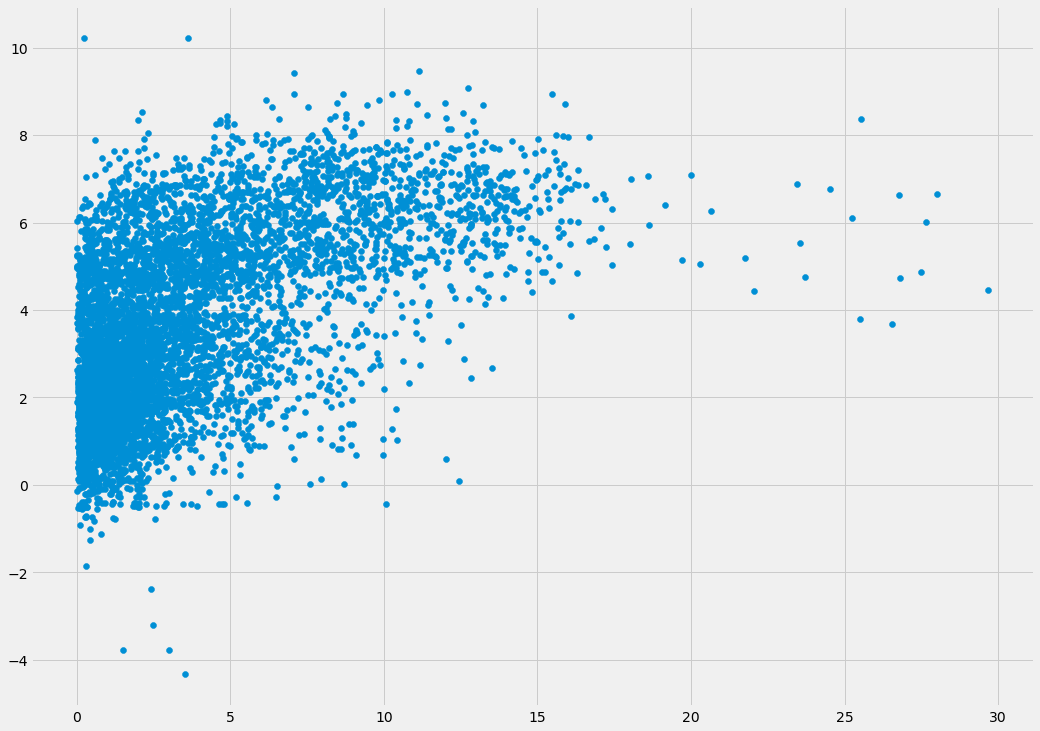

In [51]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred_validation)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

# Evaluate final optimized model

In [56]:
LR.MSE(df_pred['y_valid'], df_pred['y_pred'])

4.795146493243809

In [58]:
LR.MAE(df_pred['y_valid'], df_pred['y_pred'])

2.2005675566064076

In [55]:
df_pred.corr()

,y_valid,y_pred
y_valid,1.00000,0.56108
y_pred,0.56108,1.00000


In [79]:
x = []
y = []
for i in range(0,100):
    i = i / 10
    x.append(i)
    y.append( sum( (df_pred['y_pred'] > df_pred['y_valid'] - i)  & (df_pred['y_pred'] < df_pred['y_valid'] + i) ) / len(df_pred) )

Text(0.5, 1.0, 'Linear Regression')

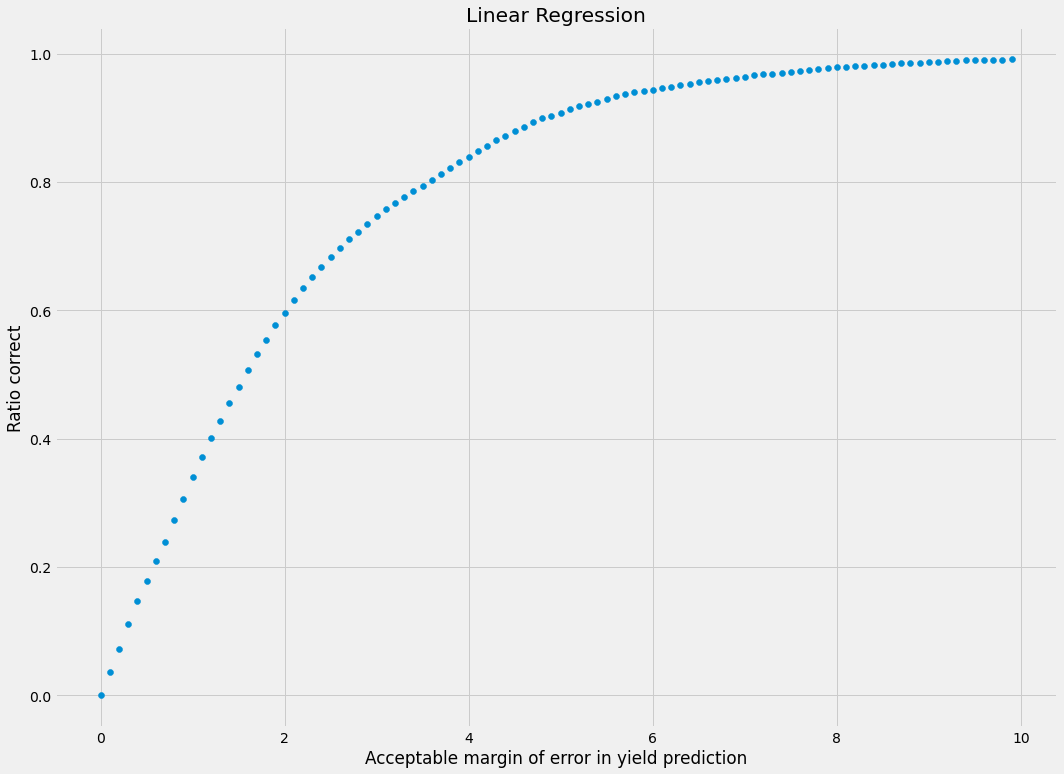

In [85]:
plt.scatter(x,y)
plt.xlabel('Acceptable margin of error in yield prediction')
plt.ylabel('Ratio correct')
plt.title('Linear Regression')

In [86]:
sum( (df_pred['y_pred'] > df_pred['y_valid'] - 2)  & (df_pred['y_pred'] < df_pred['y_valid'] + 2) ) / len(df_pred)

0.5956843597416916

## Investigate Optimization data

Text(0.5, 1.0, ' Error vs Step Size Hyperparameter')

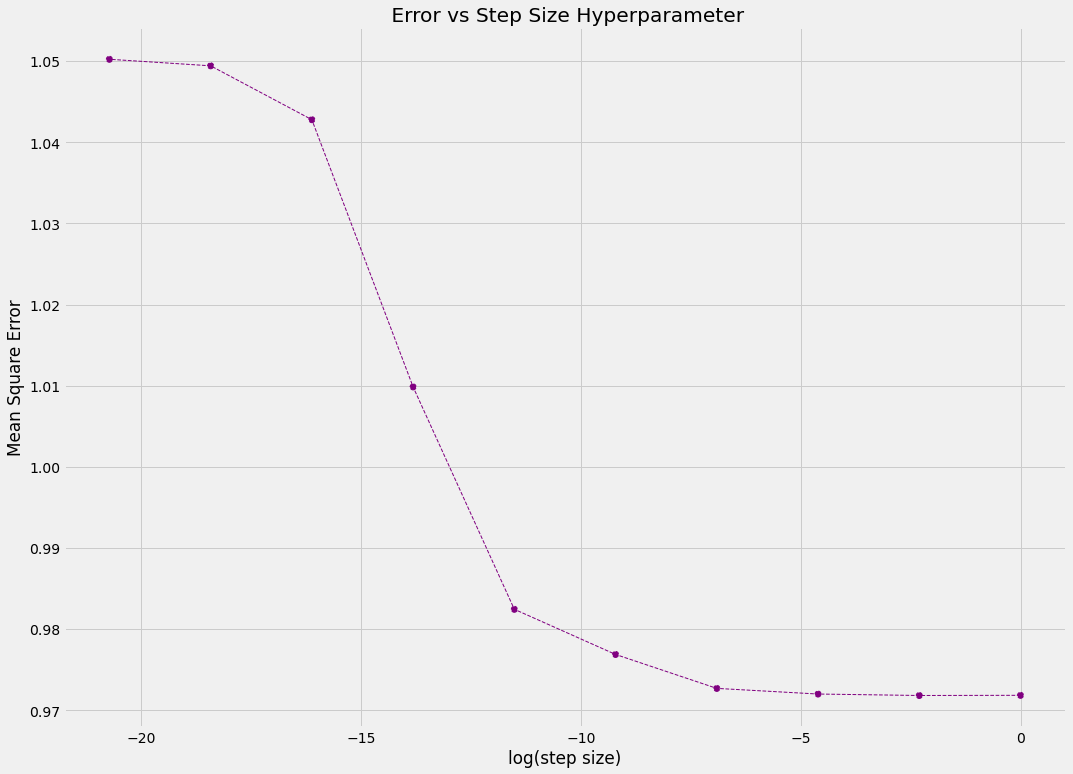

In [21]:
s = []
mse = []
for r in results:
    if r['params'][1] == 1e-8:
        s.append(r['params'][0])
        mse.append(r['MSE'])

plt.plot(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(step size)')
plt.ylabel('Mean Square Error')
plt.title(' Error vs Step Size Hyperparameter')

Text(0.5, 1.0, ' Runtime vs Step Size Hyperparameter')

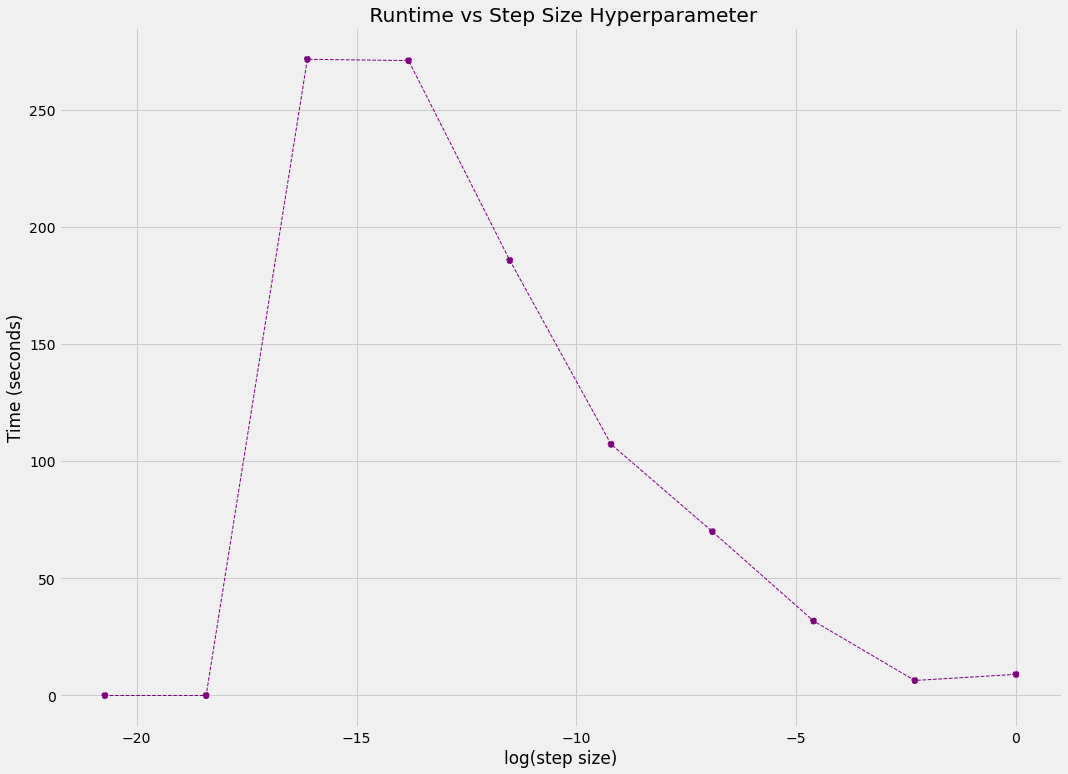

In [22]:
s = []
mse = []
for r in results:
    if r['params'][1] == 1e-7:
        s.append(r['params'][0])
        mse.append(r['runtime'])

plt.plot(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(step size)')
plt.ylabel('Time (seconds)')
plt.title(' Runtime vs Step Size Hyperparameter')

Text(0.5, 1.0, ' Error vs Convergence Threshold')

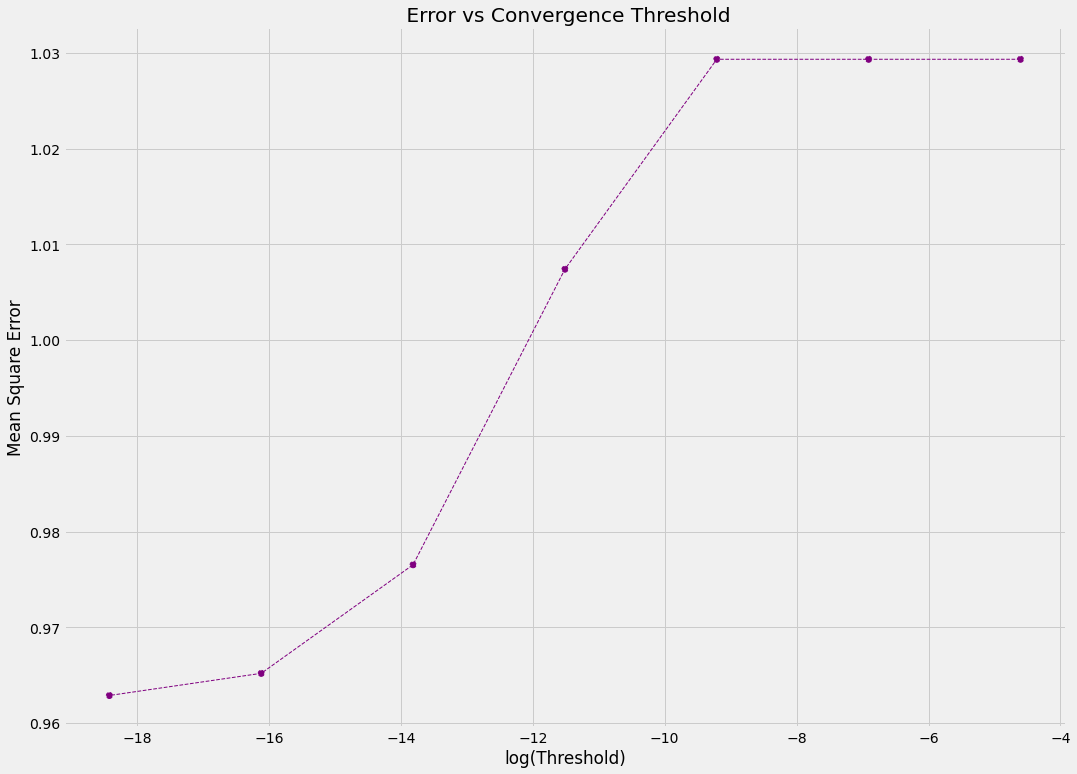

In [23]:
s = []
mse = []
for r in results:
    if r['params'][0] == 1e-5:
        s.append(r['params'][1])
        mse.append(r['MSE'])

plt.plot(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(Threshold)')
plt.ylabel('Mean Square Error')
plt.title(' Error vs Convergence Threshold')

Text(0.5, 1.0, ' Runtime vs Convergence Threshold')

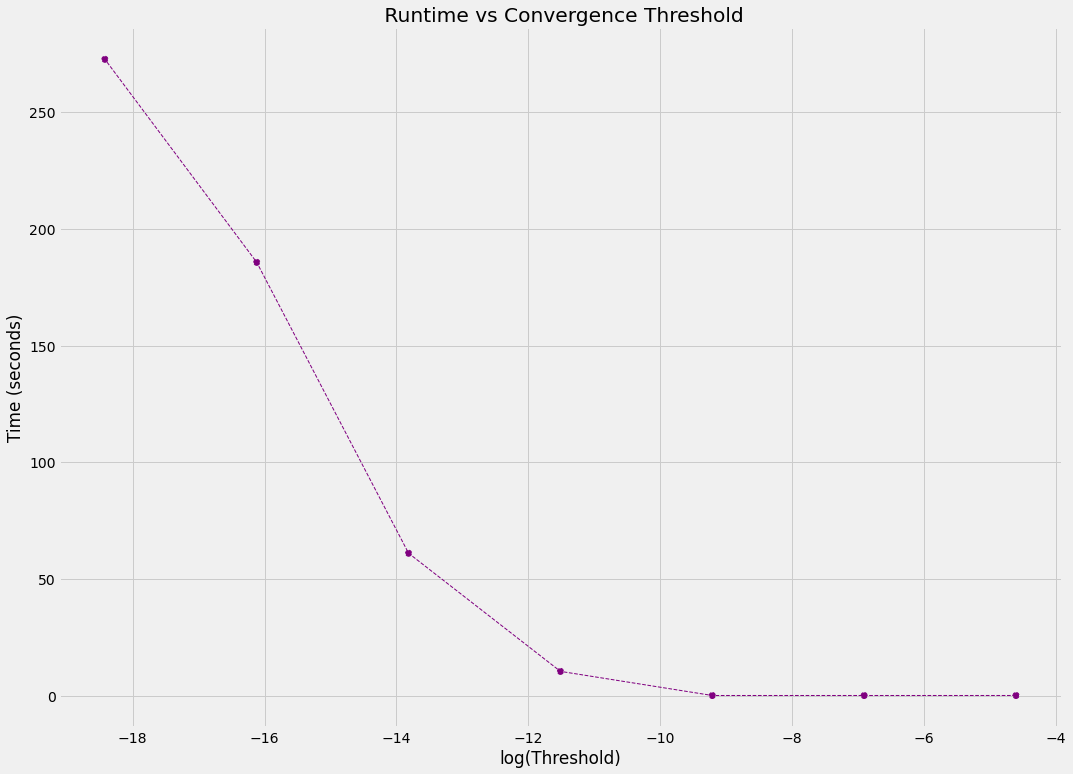

In [24]:
s = []
mse = []
for r in results:
    if r['params'][0] == 1e-5:
        s.append(r['params'][1])
        mse.append(r['runtime'])

plt.plot(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(Threshold)')
plt.ylabel('Time (seconds)')
plt.title(' Runtime vs Convergence Threshold')

# Run model on training data to detect overfitting

In [37]:
LR = Linear_Regression(x_train, y_train, x_train, y_train, 
                                                 max_iters = 1e5, 
                                                 tolerance = best_tol, 
                                                 step_size = best_step)

# fit model to training data
weights, loss = LR.fit(x_train, y_train)

# use model to make predictions from test data
y_pred_ontrain, MSE = LR.predict(x_train)

Converged!


In [38]:
y_pred_ontrain = unnormalize(y_pred_ontrain, train[1][-1],  train[2][-1])
y_train = unnormalize(y_train, train[1][-1],  train[2][-1])

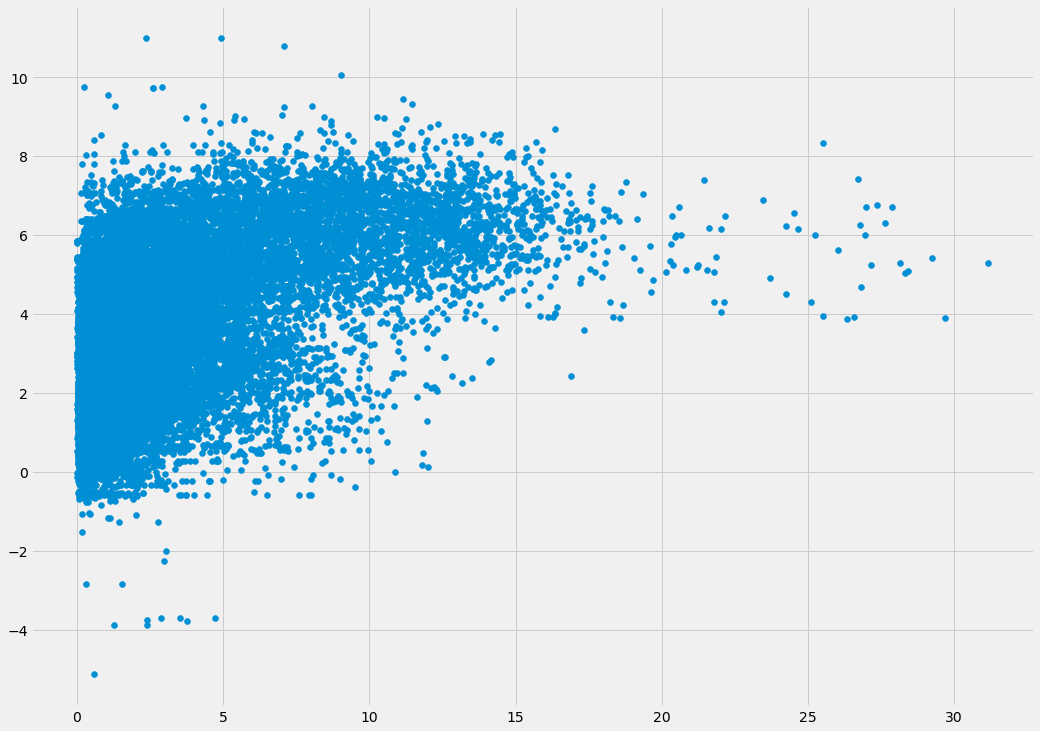

In [39]:
df_pred = pd.DataFrame(list(y_train), columns = ['y_train'])
df_pred['y_pred'] = list(y_pred_ontrain)

plt.scatter(df_pred['y_train'], df_pred['y_pred'])

In [40]:
df_pred.corr()

,y_train,y_pred
y_train,1.000000,0.553709
y_pred,0.553709,1.000000
